# 基礎行列
## 6.7 基礎行列の計算

In [1]:
import math
import sys
from itertools import product
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import random_correlation, special_ortho_group
from scipy.spatial.transform import Rotation

sys.path.append('../libs')
import util

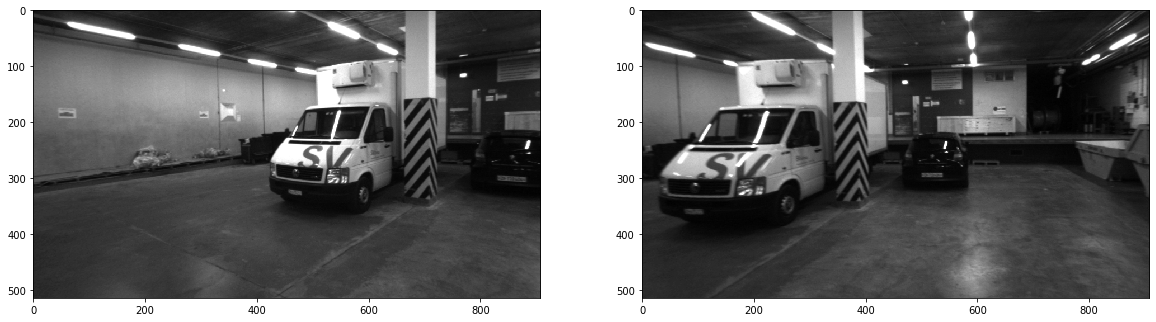

In [2]:
dir_ = Path('../delivery_area/images/images_rig_cam4_undistorted/')
assert dir_.exists()
img1 = cv2.imread(str(dir_.joinpath('1477843923158183523.png')), 0)
img2 = cv2.imread(str(dir_.joinpath('1477843922125991523.png')), 0)

plt.figure(figsize=(20, 15))
plt.subplot(121)
plt.imshow(img1, cmap='gray')
plt.subplot(122)
plt.imshow(img2, cmap='gray')
plt.show()

In [3]:
# read delivery_area/rig_calibration_undistorted/camera.txt 
K = np.array([
    [541.911, 0., 499.646],
    [0., 541.618, 231.773],
    [0., 0., 1.]
])
# read delivery_area/rig_calibration_undistorted/images.txt
# img1: 1477843923158183523.png
img1_R = Rotation.from_quat([0.68694, 0.231806, -0.232012, 0.648498]).as_dcm()
img1_t = np.array([-3.73309, -2.88463, -6.98445])
# img2: 1477843922125991523.png
img2_R = Rotation.from_quat([0.722393, 0.0652118, -0.0728687, 0.684533]).as_dcm()
img2_t = np.array([-0.800761, -2.85843, -8.17517])

answer_R = img2_R @ img1_R.T
answer_t = img2_t - img1_t

In [4]:
detector = cv2.ORB_create()

kp1, des1 = detector.detectAndCompute(img1, None)
kp2, des2 = detector.detectAndCompute(img2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)
matches = [m for m in matches if m.distance < 40]

68


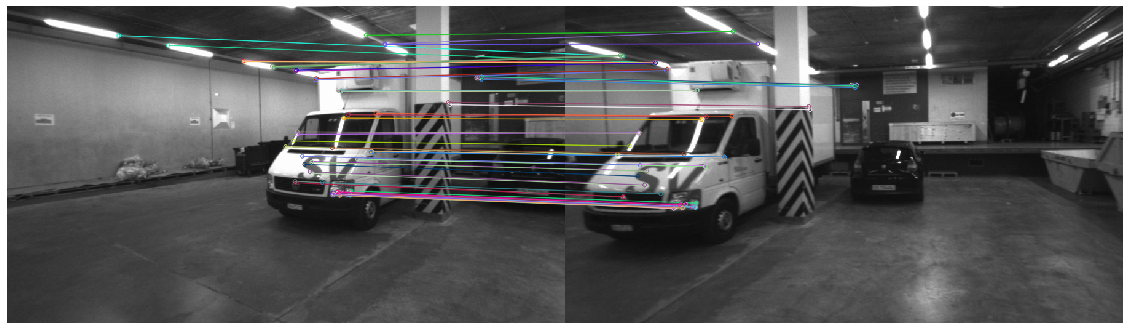

In [5]:
plt.figure(figsize=(20, 15))
plt.axis('off')
plt.imshow(cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2))
print(len(matches))

In [6]:
pts1 = np.int32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.int32([kp2[m.trainIdx].pt for m in matches])

In [7]:
def preprocess(pts, f_0):
    assert pts.shape[1] == 2
    return np.vstack([pts.T / f_0, np.ones(pts.shape[0])])

In [8]:
f_0 = 400
X_prime = preprocess(pts1, f_0)
X = preprocess(pts2, f_0)
assert X.shape == X_prime.shape
print(X.shape)

(3, 68)


In [9]:
def init_F(X, X_prime):
    Xi = X.reshape(3, 1, -1) * X_prime.reshape(1, 3, -1)
    M = (Xi.reshape(9, 1, -1) * Xi.reshape(1, 9, -1)).mean(axis=2)
    w, v = np.linalg.eigh(M)
    q = v[:, np.argmin(w)]
    F = q.reshape(3, 3)
    u, s, vh = np.linalg.svd(F)
    phi = math.atan2(s[1], s[0])
    return u @ np.diag([math.cos(phi), math.sin(phi), 0.]) @ vh, u, vh.T, phi

In [10]:
def calc_J(X, X_prime, F):
    P_k = np.diag([1., 1., 0.])
    numer = (F @ X_prime * X).sum(axis=0)**2
    denom = ((P_k @ F @ X_prime)**2 + (P_k @ F.T @ X_prime)**2).sum(axis=0)
    assert denom.shape == numer.shape == (X.shape[1],)
    return f_0**2 / 2 * (numer / denom).sum()

In [11]:
def differentiate_J_by_F(X, X_prime, F):
    P_k = np.diag([1., 1., 0.])
    dJ_dF = np.zeros(9)
    d2J_dFF = np.zeros([9, 9])
    denom = ((P_k @ F @ X_prime)**2 + (P_k @ F.T @ X_prime)**2).sum(axis=0)
    assert denom.shape == (X.shape[1],)
    for i, j in product(range(3), repeat=2):
        numer = X[i] * X_prime[j] * (X * (F @ X_prime)).sum(axis=0)
        assert denom.shape == numer.shape
        dJ_dF[3*i+j] = f_0**2 * (numer / denom).sum()
    for i, j, k, l in product(range(3), repeat=4):
        numer = X[i] * X_prime[j] * X[k] * X_prime[l]
        assert denom.shape == numer.shape
        d2J_dFF[3*i+j, 3*k+l] = f_0**2 * (numer / denom).sum()
    return dJ_dF, d2J_dFF

In [12]:
def calc_F_UV(F):
    F_U = np.array([
        [0, 0, 0, -F[2, 0], -F[2, 1], -F[2, 2], F[1, 0], F[1, 1], F[1, 2]],
        [F[2, 0], F[2, 1], F[2, 2], 0, 0, 0, -F[0, 0], -F[0, 1], -F[0, 2]],
        [-F[1, 0], -F[1, 1], -F[1, 2], F[0, 0], F[0, 1], F[0, 2], 0, 0, 0],
    ]).T
    F_V = np.array([
        [0, -F[0, 2], F[0, 1], 0, -F[1, 2], F[1, 1], 0, -F[2, 2], F[2, 1]],
        [F[0, 2], 0, -F[0, 0], F[1, 2], 0, -F[1, 0], F[2, 2], 0, -F[2, 0]],
        [-F[0, 1], F[0, 0], 0, -F[1, 1], F[1, 0], 0, -F[2, 1], F[2, 0], 0]
        
    ]).T
    assert F_U.shape == F_V.shape == (9, 3)
    return F_U, F_V

In [13]:
def calc_theta_phi(U, V, phi):
    return (math.cos(phi) * np.outer(U[:,1], V[:,1]) - \
            math.sin(phi) * np.outer(U[:,0], V[:,0])).reshape(-1)

In [14]:
def optimize_F(X, X_prime):
    # step 1
    F, U, V, phi = init_F(X, X_prime)
    J = calc_J(X, X_prime, F)
    c = 0.0001
    while True:
        # step 2
        dJ_dF, d2J_dFF = differentiate_J_by_F(X, X_prime, F)
        # step 3
        F_U, F_V = calc_F_UV(F)
        theta_phi = calc_theta_phi(U, V, phi)
        # step 4
        dJ_dωU = F_U.T @ dJ_dF
        dJ_dωV = F_V.T @ dJ_dF
        dJ_dφ = np.inner(dJ_dF, theta_phi)
        d2J_dωUωU = F_U.T @ d2J_dFF @ F_U
        d2J_dωVωV = F_V.T @ d2J_dFF @ F_V
        d2J_dωUωV = F_U.T @ d2J_dFF @ F_V
        d2J_dωUφ = np.c_[F_U.T @ d2J_dFF @ theta_phi]
        d2J_dωVφ = np.c_[F_V.T @ d2J_dFF @ theta_phi]
        d2J_dφφ = np.inner(theta_phi, d2J_dFF @ theta_phi)
        while True:
            # step 5
            A = np.block([
                [d2J_dωUωU,   d2J_dωUωV,  d2J_dωUφ],
                [d2J_dωUωV.T, d2J_dωVωV,  d2J_dωVφ],
                [d2J_dωUφ.T,  d2J_dωVφ.T, d2J_dφφ]
            ])
            b = -np.block([dJ_dωU, dJ_dωV, dJ_dφ])
            x = np.linalg.solve(A + c * np.eye(A.shape[0]), b)
            # step 6
            new_U = util.exponential_map(x[:3]) @ U
            new_V = util.exponential_map(x[3:6]) @ V
            new_phi = phi + x[-1]
            # step 7
            new_F = new_U @ np.diag([math.cos(new_phi), math.sin(new_phi), 0.]) @ new_V.T
            # step 8
            new_J = calc_J(X, X_prime, new_F)
            # step 9
            if new_J <= J:
                break
            c *= 10

        # step 10
        if np.abs(new_F - F).sum() < 1e-10:
            return new_F
        F, U, V, phi = new_F, new_U, new_V, new_phi
        J = new_J
        c /= 10

In [15]:
F = optimize_F(X, X_prime)
scale_vec = np.array([1 / f_0, 1 / f_0, 1.])
scale_mat = np.outer(scale_vec, scale_vec)
F *= scale_mat
print(F)

[[-2.07641117e-07 -2.76256123e-06  4.82169588e-04]
 [ 2.79128077e-06 -2.87077038e-07 -1.65036283e-03]
 [-3.01618758e-04  8.24025248e-04  7.59580858e-02]]


In [16]:
def drawlines(img, lines, pts):
    _, cols = img.shape
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for (a, b, c), pt in zip(lines, pts):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = 0, int(-c / b)
        x1, y1 = cols, int(-(c + a * cols) / b)
        img = cv2.line(img, (x0, y0), (x1, y1), color, 1)
        img = cv2.circle(img, tuple(pt), 5, color, -1)
    return img

In [17]:
def draw_epipolar(img1, img2, pts1, pts2, F):
    lines1 = cv2.computeCorrespondEpilines(pts2, 2, F)[:, 0, :]
    lines2 = cv2.computeCorrespondEpilines(pts1, 1, F)[:, 0, :]
    img3 = drawlines(img1, lines1, pts1)
    img4 = drawlines(img2, lines2, pts2)

    plt.figure(figsize=(20, 15))
    plt.subplot(121)
    plt.axis('off')
    plt.imshow(img3)
    plt.subplot(122)
    plt.axis('off')
    plt.imshow(img4)
    plt.show()

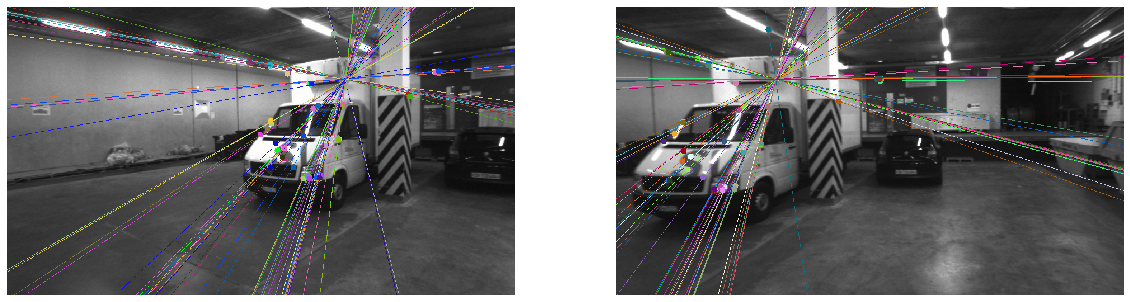

In [18]:
draw_epipolar(img1, img2, pts1, pts2, F)

In [19]:
def solve_Rt(F, K):
    E = K.T @ F @ K
    U, S, VT = np.linalg.svd(E)
    W = np.array([
        [0., -1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]
    ])
    return U @ W @ VT, U @ W.T @ VT, U[:, 2], -U[:, 2]

In [20]:
R1, R2, t1, t2 = solve_Rt(F, K)
print(R1)
print(R2)
print(t1)
print(t2)

[[-0.97417956  0.16264166 -0.15659462]
 [-0.10203995 -0.93587799 -0.33722433]
 [-0.20140019 -0.31253814  0.92830915]]
[[ 0.83858803 -0.02984023 -0.54394824]
 [ 0.03728428  0.99930116  0.00265976]
 [ 0.54348874 -0.02251116  0.83911456]]
[-0.3628986  -0.17331275  0.91556938]
[ 0.3628986   0.17331275 -0.91556938]


In [21]:
print('rotation error:', util.eval_R_error(R2, answer_R))
print('translation error:', np.abs(t2 - answer_t).sum())

rotation error: 0.11779720833708139
translation error: 2.9916937694806838


## おまけ (OpenCV)

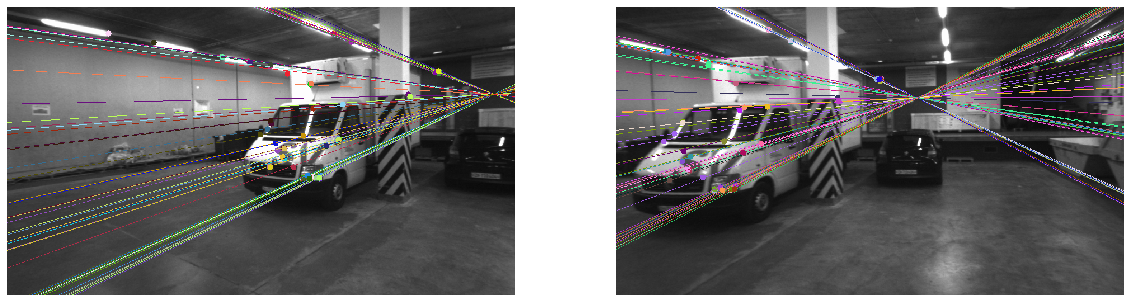

In [22]:
F2, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_LMEDS)
draw_epipolar(img1, img2, pts1, pts2, F2)

In [23]:
R3, R4, t3, t4 = solve_Rt(F2, K)
print(R3)
print(R4)
print(t3)
print(t4)

[[-0.7829393  -0.00747082  0.62205325]
 [-0.14369893 -0.97071392 -0.19252302]
 [ 0.60527405 -0.24012222  0.75893652]]
[[ 8.62414143e-01 -8.74896294e-03 -5.06127752e-01]
 [ 8.20795682e-04  9.99873484e-01 -1.58852982e-02]
 [ 5.06202698e-01  1.32842783e-02  8.62312215e-01]]
[ 0.07074258 -0.12717947  0.98935376]
[-0.07074258  0.12717947 -0.98935376]


In [24]:
print('rotation error:', util.eval_R_error(R4, answer_R))
print('translation error:', np.abs(t4 - answer_t).sum())

rotation error: 0.06818191901302754
translation error: 3.305417286260671
